# Workshop sur l’optimisation de portefeuille - Dim 5 nov - 10h

Ce workshop est destiné à vous outiller afin de concevoir le module qui vous permettra de
faire la sélection des titres et le balancement de votre portefeuille.

Les sujets abordés sont: 

- Différentes stratégies (trend following, mean-reversion, ...)
- Modèle de Markowitz
- Modèles à facteurs (Fama French)

Pour chaque section, une capsule théorique ainsi que l'application de celle-ci via des librairies python vous serons fournis.

*Le jeu de données utilisé dans ce workhop est identique à celui du défis du datathon*
*Veuillez suivre les guides d'installation fourni pour faire le setup de ce worksop*


In [1]:
#!pip install pandas seaborn matplotlib numpy statsmodels scikit-learn


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import plotly
import cufflinks
import plotly.express as px

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

## Loading data

In [3]:
ROOT='./kaggle/input/dt23-test/' # remove the dot (.) for the kaggle version

In [4]:
adjusted_close = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close.index = pd.to_datetime(adjusted_close.index)
adjusted_close = adjusted_close.dropna(axis=1).iloc[:, :20]

adjusted_close.shape

(6022, 20)

## Modèle de Markowitz

https://www.math.hkust.edu.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf

### Génération de portfolios non optimaux aléatoirement

Nous allons générer des portfolio non-optimal contenants les 20 premières actions de notre jeux de donnée, soit le S&P 500. Nous allons utiliser l'ensemble des observations de notre jeux pour chacun de ces actifs soit le prix de fermeture pour l'ensemble des 6022 jours.

Dans le code ci-dessous, nous créons un vecteur des rendements journaliers de chaque action. Nous représentant grapgiquement ceux-ci à travers le temps.


Text(0, 0.5, 'Rendement')

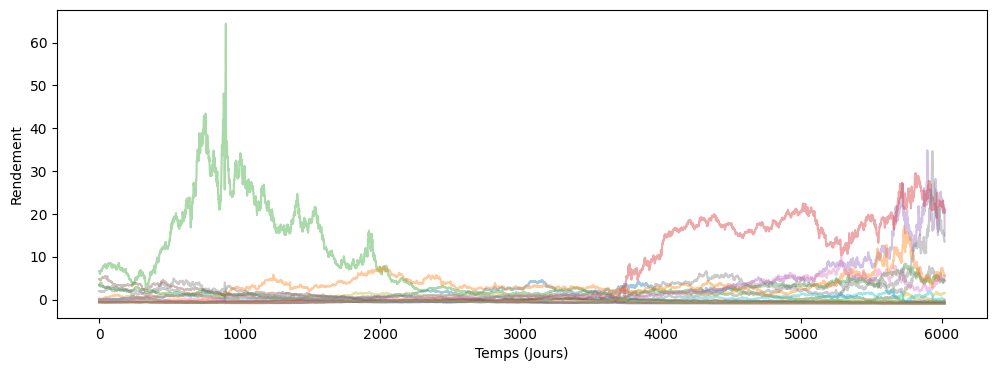

In [5]:
returns = adjusted_close.T.pct_change().dropna() # calcul rendement journalier
return_vec = returns.values

fig = plt.figure(figsize=(12,4))
plt.plot(return_vec.T, alpha=.4)
plt.xlabel('Temps (Jours)') 
plt.ylabel('Rendement')

Nous allons maintenant gérérer 1000 portfolios avec des poids aléatoires tout en respectant notre facteur de risque arbitraire, soit que σ > 2.

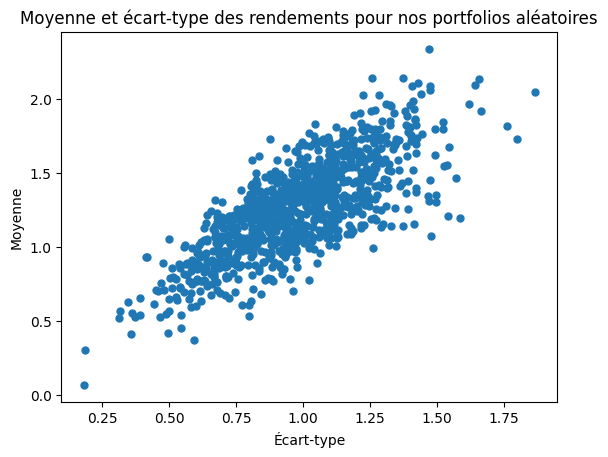

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def random_weights(n):
    """
        Retourne une liste de n poids dont la somme donne 1.
    """
    w_i = np.random.rand(n)
    return w_i / sum(w_i)

def random_portfolio(returns):
    """
        Retourne la moyenne et l'écart type du rendement de notre portfolio généré aléatoirement.
    """
    n_assets = returns.shape[0]  # Number of assets

    W = np.asmatrix(random_weights(n_assets)).T
    R = np.asmatrix(np.mean(returns, axis=1)).T
    COV = np.asmatrix(np.cov(returns))
    
    µ = W.T * R
    σ = np.sqrt(W.T * COV * W)

    if σ > 2:
        return random_portfolio(returns)
    return µ, σ

n_portfolios = 1000
means, stds = np.column_stack([
    random_portfolio(return_vec)
    for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('Écart-type')
plt.ylabel('Moyenne')
plt.title('Moyenne et écart-type des rendements pour nos portfolios aléatoires')
plt.show()


### Création du portefeuille optimale

Maintenant que nous avons vu le retour moyen  de nos portefolios aléatoires, touvons un portefolio optimal soit qui nous donne un meilleur rendement.
Nous cherchons a calculer notre frontière d'efficience en minimisant 

Pour traiter nos matrices, nous utiliserons la librairie CVXOPT (https://cvxopt.org/index.html) :
- blas: https://cvxopt.org/userguide/blas.html
- solvers: https://cvxopt.org/userguide/coneprog.html





Nous utiliserons le même modèle prédictif fourni dans le challenge pour prédire le rendement des actifs choisis.

Le modèle actuel est très simpliste:
- `polynomial_regression`: effectue une simple régression avec un polynome du 3e degré pour essayer de prédire le rendement que fera chaque titre le lendemain.

In [7]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(past_prices):
    """
        Fits a 3d degree polynomial for each asset and returns the predicted value
    """

    models={}

    # Fitting a 3d degree polynomial for each asset
    for c in past_prices.columns:
        x=past_prices[[c]]
        xp = PolynomialFeatures(degree=3).fit_transform(np.arange(len(x)).reshape((len(x),1)))
        model = sm.OLS(x.values, xp).fit()
        models[c] = model

    # Returning the expected return for the next timestep for all stocks
    return pd.DataFrame({k:v.predict(PolynomialFeatures(degree=3).fit_transform(np.array([len(x)]).reshape((1,1)))) for k,v in models.items()})/past_prices.iloc[-1]


In [8]:
def create_markowitz_portfolio(returns, predictions):

    n_assets, n_days = returns.shape
    returns = np.asmatrix(returns)

    rolling_window = 30
    rolling_risks = [returns[:, i - rolling_window + 1:i + 1].std() for i in range(rolling_window - 1, n_days)]
    
    N = 50
    µs = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    S = opt.matrix(np.cov(returns))
    r = opt.matrix(predictions)

    G = -opt.matrix(np.eye(n_assets))
    h = opt.matrix(0.0, (n_assets, 1))
    A = opt.matrix(1.0, (1, n_assets))
    b = opt.matrix(1.0)

    portfolios = []
    portfolio_returns = []
    portfolio_risks = []

    for µ in µs:
        µS = µ * S
        wt = solvers.qp(µS, -r, G, h, A, b)['x']
        portfolios.append(wt)
        
        portfolio_return = blas.dot(r, wt)
        portfolio_returns.append(portfolio_return)
        
        portfolio_risk = np.sqrt(blas.dot(wt, S * wt) + µ ** 2 * rolling_risks[-1])
        portfolio_risks.append(portfolio_risk)

    m1 = np.polyfit(portfolio_returns, portfolio_risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    optimal_weights = solvers.qp(opt.matrix(x1 * S), -r, G, h, A, b)['x']
    optimal_weights = np.asarray(optimal_weights)
    portfolio_returns = np.asarray(portfolio_returns)
    portfolio_risks = np.asarray(portfolio_risks)

    print("Optimal Weights:", optimal_weights)
    print("Portfolio Returns:", portfolio_returns)
    print("Portfolio Risks (Volatility):", portfolio_risks)

    return optimal_weights, portfolio_returns, portfolio_risks

last_30_days = adjusted_close.iloc[:30]
predictions = polynomial_regression(last_30_days).T.to_numpy()[1:] # On drop le 1er actif, car nous l'avion drop précédemment
weights, returns, risks = create_markowitz_portfolio(return_vec, predictions)

Optimal Weights: [[1.55167090e-02]
 [4.36342278e-06]
 [7.39606553e-08]
 [4.50874564e-06]
 [3.14948471e-07]
 [6.34218179e-07]
 [8.80085743e-07]
 [1.64353365e-06]
 [1.51542694e-06]
 [1.25473729e-01]
 [3.87867218e-05]
 [8.45529715e-03]
 [1.36443681e-06]
 [9.71829847e-03]
 [8.40775207e-01]
 [1.42633662e-06]
 [2.17317156e-06]
 [1.69041188e-06]
 [1.38409915e-06]]
Portfolio Returns: [1.02307353 1.02240129 1.02186725 1.0214437  1.02110286 1.02054796
 1.019991   1.0195116  1.01907175 1.01872314 1.01844603 1.01822251
 1.01786711 1.0173765  1.01674411 1.01582152 1.01498478 1.01431019
 1.01351927 1.01274386 1.01204417 1.0114842  1.01103926 1.01068577
 1.0096253  1.00852421 1.00764776 1.00680027 1.00578182 1.00497233
 1.00432834 1.00381654 1.00341006 1.0030872  1.00283068 1.00262694
 1.00246508 1.00233639 1.00223413 1.00215109 1.00208584 1.00203356
 1.00199163 1.00195814 1.00193151 1.00191035 1.00189353 1.00188018
 1.00186958 1.00186115]
Portfolio Risks (Volatility): [3.45396616e-01 3.87995359e-01 

### Graphe avec frontière efficiente et nuage de points

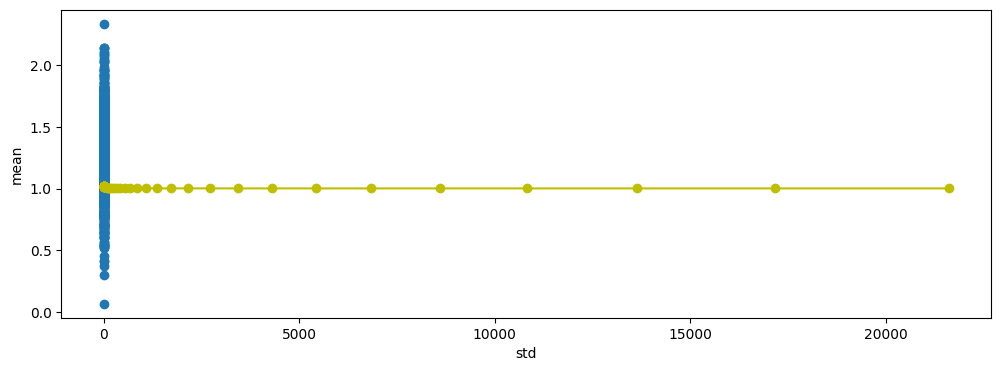

In [9]:
fig = plt.figure(figsize=(12, 4))
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [10]:
weights

array([[1.55167090e-02],
       [4.36342278e-06],
       [7.39606553e-08],
       [4.50874564e-06],
       [3.14948471e-07],
       [6.34218179e-07],
       [8.80085743e-07],
       [1.64353365e-06],
       [1.51542694e-06],
       [1.25473729e-01],
       [3.87867218e-05],
       [8.45529715e-03],
       [1.36443681e-06],
       [9.71829847e-03],
       [8.40775207e-01],
       [1.42633662e-06],
       [2.17317156e-06],
       [1.69041188e-06],
       [1.38409915e-06]])

## Rebalancement journalier avec Markowitz

Vous choisissez ici ce que vous fournissez aux fonctions précédemment implémentées.

L'utilisation de `rolling()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)) est pratiquement obligatoire pour éviter d'incorporer les données futures dans votre système.

Si vous ne respectez pas l'intervalle `2000-01-01`-`2006-01-01` votre solution ne sera pas acceptée.

In [11]:
weights_df = []
index = []
adjusted_close=adjusted_close.sort_index()
start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2006-01-01')
for x in adjusted_close[(adjusted_close.index>=pd.to_datetime(start))&(adjusted_close.index<pd.to_datetime(stop))].rolling(30):
    if len(x)==30:
        index.append(x.index.max())
        ret = x.T.pct_change().dropna()
        ret_vec = ret.values
        pred = polynomial_regression(x).T.to_numpy()[1:]
        weights = pd.Series({"weight_"+a.split('_')[-1]:b[0] for a,b in zip(x.columns,create_markowitz_portfolio(ret_vec, pred)[0][:])})
        print(weights)
        weights_df.append(weights)


Optimal Weights: [[5.47785185e-09]
 [6.55885373e-09]
 [6.21833924e-09]
 [9.99999557e-01]
 [2.33989227e-07]
 [7.20421220e-09]
 [7.39918754e-09]
 [8.32705573e-09]
 [6.01085952e-09]
 [6.00701590e-09]
 [1.91046962e-09]
 [4.92270993e-09]
 [4.82349690e-09]
 [3.92187015e-09]
 [6.84329180e-09]
 [4.38332398e-09]
 [3.89299985e-09]
 [1.18958071e-07]
 [5.66701809e-09]]
Portfolio Returns: [1.16523074 1.16523074 1.16523073 1.16523073 1.16523073 1.16523073
 1.16523073 1.16523072 1.16523072 1.16523072 1.1652307  1.16523067
 1.16523063 1.16523053 1.16523017 1.16522873 1.16523045 1.16522159
 1.16519338 1.16516673 1.16514661 1.16513029 1.16511732 1.16510701
 1.16509879 1.16509227 1.16508705 1.1650828  1.16507942 1.16507651
 1.16507506 1.16507307 1.16504999 1.16496317 1.16487696 1.16478868
 1.16443736 1.16395566 1.16357218 1.16326803 1.16302632 1.16283436
 1.16268137 1.16256094 1.1623625  1.16203146 1.16176207 1.16154294
 1.15827604 1.15550223]
Portfolio Risks (Volatility): [2.81123537e-01 3.53871698e-01 

Génération de la soumission avec le format requis.

In [12]:
weights_df_csv = pd.DataFrame(weights_df, index=index)
weights_df_csv.to_csv('sample_submission.csv')
weights_df_csv

weight_CSCO    weight_DVN    weight_MRO     weight_BA  \
2000-02-14  5.477852e-09  6.558854e-09  6.218339e-09  9.999996e-01   
2000-02-15  5.226106e-09  5.447412e-09  5.062292e-09  9.999997e-01   
2000-02-16  3.824827e-09  3.824240e-09  4.148873e-09  9.999999e-01   
2000-02-17  1.526026e-07  2.387961e-07  2.486946e-07  1.386153e-06   
2000-02-18  5.680239e-09  4.924948e-09  4.560749e-09  1.890769e-09   
...                  ...           ...           ...           ...   
2005-12-23  6.582924e-08  9.472190e-08  1.377875e-07  2.767715e-07   
2005-12-27  1.399333e-07  2.854096e-07  3.124195e-07  1.047249e-06   
2005-12-28  1.255360e-09  2.213768e-09  3.256120e-09  7.905408e-01   
2005-12-29  3.999876e-08  5.633498e-08  8.062498e-08  5.104316e-01   
2005-12-30  1.438164e-07  1.890220e-07  4.617989e-07  4.152064e-01   

             weight_GILD    weight_MDT     weight_MO   weight_CTRA  \
2000-02-14  2.339892e-07  7.204212e-09  7.399188e-09  8.327056e-09   
2000-02-15  1.455333e-07  5.904690e-09  6.029001e-09  6.216764e-09   
2000-02-16  5.568903e-08  3.872634e-09  4.068872e-09  1.464834e-09   
2000-02-17  2.177030e-06  2.365299e-07  2.493625e-07  4.027597e-08   
2000-02-18  1.815884e-08  4.156991e-09  4.273790e-09  4.719039e-09   
...                  ...           ...           ...           ...   
2005-12-23  4.937878e-01  2.885430e-06  5.062074e-01  4.351634e-08   
2005-12-27  2.242480e-07  4.458294e-07  8.889158e-01  1.582020e-07   
2005-12-28  1.445566e-09  4.016922e-09  2.324347e-09  3.264194e-09   
2005-12-29  1.104792e-07  1.291155e-07  5.908355e-08  1.176882e-07   
2005-12-30  5.371198e-07  5.829285e-07  1.514377e-07  1.021623e-06   

             weight_MCHP    weight_EIX    weight_BBY    weight_GEN  \
2000-02-14  6.010860e-09  6.007016e-09  1.910470e-09  4.922710e-09   
2000-02-15  5.096579e-09  6.056693e-09  1.460884e-09  4.397641e-09   
2000-02-16  3.646596e-09  3.752723e-09  5.034473e-10  2.865770e-09   
2000-02-17  2.247269e-07  2.309234e-07  1.421845e-06  2.887439e-07   
2000-02-18  4.144677e-09  4.020862e-09  6.035061e-09  5.739042e-09   
...                  ...           ...           ...           ...   
2005-12-23  7.036230e-08  2.650507e-08  3.584780e-08  9.192218e-08   
2005-12-27  1.324215e-07  1.125018e-07  1.011999e-07  1.892564e-07   
2005-12-28  1.660736e-09  2.784572e-09  1.945095e-09  1.939760e-09   
2005-12-29  3.507366e-08  8.450123e-08  6.431514e-08  7.533661e-08   
2005-12-30  1.616903e-07  4.724696e-02  2.970257e-07  2.371736e-07   

              weight_WBA    weight_DTE      weight_C      weight_T  \
2000-02-14  4.823497e-09  3.921870e-09  6.843292e-09  4.383324e-09   
2000-02-15  4.362035e-09  3.765364e-09  5.744699e-09  6.555738e-09   
2000-02-16  3.663352e-09  3.746436e-09  3.912548e-09  1.671721e-09   
2000-02-17  2.230927e-07  3.584342e-07  2.226784e-07  9.999893e-01   
2000-02-18  4.186194e-09  5.979453e-09  3.691640e-09  9.999999e-01   
...                  ...           ...           ...           ...   
2005-12-23  2.264550e-07  1.433954e-07  7.468615e-08  7.267950e-08   
2005-12-27  2.714187e-07  2.590038e-07  1.710147e-07  2.455567e-07   
2005-12-28  3.214626e-09  3.015662e-09  2.659129e-09  2.309416e-09   
2005-12-29  1.165344e-07  1.004198e-07  9.002719e-08  5.866026e-08   
2005-12-30  4.556407e-07  4.104174e-07  4.793667e-07  3.194745e-07   

              weight_APH    weight_SYY    weight_MSI  
2000-02-14  3.893000e-09  1.189581e-07  5.667018e-09  
2000-02-15  3.696221e-09  5.876268e-08  5.202474e-09  
2000-02-16  2.940439e-09  2.732290e-08  3.874121e-09  
2000-02-17  2.574393e-07  2.512139e-06  2.358115e-07  
2000-02-18  5.190538e-09  1.976138e-08  4.932965e-09  
...                  ...           ...           ...  
2005-12-23  1.732252e-07  2.108539e-07  1.242696e-07  
2005-12-27  3.118327e-07  1.110795e-01  2.855612e-07  
2005-12-28  4.042388e-09  2.094592e-01  2.813383e-09  
2005-12-29  7.599537e-08  4.895671e-01  8.801885e-08  
2005-12-30  2.885325e-07  5.375403e-01  5.17

## Evaluation

In [13]:
prices_df = adjusted_close.iloc[:, 1:].loc[weights_df_csv.index] #On drop encore une fois le premier actif
returns_df = prices_df.shift(-1)/prices_df


In [14]:
bmrk = pd.read_csv(ROOT+'series/benchmark/SPY_returns.csv',index_col=0)
bmrk.index = pd.to_datetime(bmrk.index)


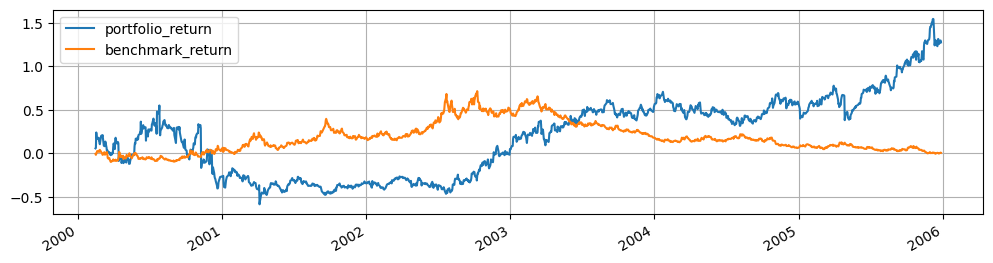

In [15]:
porfolio_performance = pd.DataFrame(pd.DataFrame(returns_df.values*weights_df_csv.values, columns=weights_df_csv.columns, index=weights_df_csv.index).sum(axis=1),columns=['portfolio_return'])[:-2]
daily_returns = porfolio_performance.merge(bmrk,left_index=True,right_index=True,how='left')-1
cumulative_returns = ((daily_returns+1).cumprod()-1)
cumulative_returns.plot(figsize=(12,3))
plt.grid()


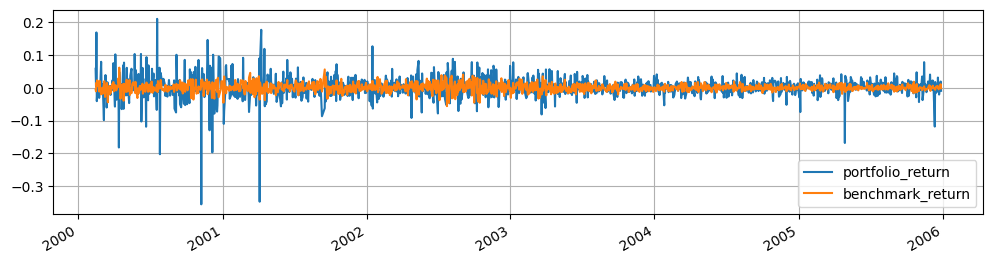

In [16]:
daily_returns.plot(figsize=(12,3))
plt.grid()


In [17]:
cov_matrix = daily_returns.cov()
beta = cov_matrix['portfolio_return']['benchmark_return']/cov_matrix['benchmark_return']['benchmark_return']
beta


-0.07216629883738758

In [18]:
us10bond = pd.read_csv(ROOT+'series/additional_data/us_10ybond_yield.csv',index_col=0)
us10bond.index = pd.to_datetime(us10bond.index)

usCPI = pd.read_csv(ROOT+'series/additional_data/us_CPI.csv',index_col=0)
usCPI.index = pd.to_datetime(usCPI.index)

cpi_idx = lambda x:usCPI[usCPI.index<=pd.to_datetime(x)].index.max()
cumulative_inflation = lambda a,b:(usCPI.loc[cpi_idx(b)]['CPI']-usCPI.loc[cpi_idx(a)]['CPI'])/usCPI.loc[cpi_idx(a)]['CPI']

# risk free rate = 10y bond yield/inflation
rf = ((1+us10bond[us10bond.index<=start].sort_index()['Yield'].values[-1])/100)/cumulative_inflation(start,stop) - 1

# returns
r = cumulative_returns['portfolio_return'].values[-1]
rm = cumulative_returns['benchmark_return'].values[-1]

alpha = r-rf-beta*(rm-rf)
alpha


1.8937696996230329

In [19]:
rf,r,rm,alpha,beta


(-0.574566782935191,
 1.2772856461069595,
 0.006275954688565788,
 1.8937696996230329,
 -0.07216629883738758)

Return over Max Drawdown

In [20]:
# https://www.investopedia.com/terms/r/return-over-maximum-drawdown-romad.asp
max_draw_down = ((cumulative_returns.cummax()-cumulative_returns)).max()
c_return = cumulative_returns.iloc[-1]
c_return/max_draw_down

portfolio_return    1.122412
benchmark_return    0.008708
dtype: float64

# Modèles à facteurs (Fama French)

Nous allons maintenant explorer une nouvelle méthode: